In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [25]:
import glob
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [26]:
from sklearn.metrics import classification_report

In [4]:
# --- Configuration ---
DATASET_BASE_PATH = "C:/Users/Pojesh/Documents/OfficialWorks/MV_Project/Dataset/affectnet/YOLO_format" 
TRAIN_DIR = os.path.join(DATASET_BASE_PATH, "train_augmented/images") 
VALID_DIR = os.path.join(DATASET_BASE_PATH, "valid/images") 
TEST_DIR = os.path.join(DATASET_BASE_PATH, "test/images")   

In [5]:
IMG_SIZE = (96, 96)
IMG_CHANNELS = 3 # (RGB)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS)
NUM_CLASSES = 8
CLASS_NAMES = [ 
    "Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"
]

In [6]:
BATCH_SIZE = 16
EPOCHS = 20
MODEL_SAVE_PATH = 'dcnn_model1.h5.keras'

In [7]:
DATASET_BASE_PATH = "C:/Users/Pojesh/Documents/OfficialWorks/MV_Project/Dataset/affectnet/YOLO_format" 
TRAIN_IMG_DIR = os.path.join(DATASET_BASE_PATH, "train_augmented/images")
TRAIN_LBL_DIR = os.path.join(DATASET_BASE_PATH, "train_augmented/labels")
VALID_IMG_DIR = os.path.join(DATASET_BASE_PATH, "valid/images")
VALID_LBL_DIR = os.path.join(DATASET_BASE_PATH, "valid/labels")
TEST_IMG_DIR = os.path.join(DATASET_BASE_PATH, "test/images")
TEST_LBL_DIR = os.path.join(DATASET_BASE_PATH, "test/labels")

In [8]:
IMG_SIZE = (96, 96)
IMG_CHANNELS = 3
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS)
NUM_CLASSES = 8
CLASS_NAMES = [
    "Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"
]
BATCH_SIZE = 16

In [9]:
def get_image_label_pairs(img_dir, lbl_dir):
    """Finds corresponding image and label files."""
    # Get all image files with supported extensions
    image_paths = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_paths.extend(glob.glob(os.path.join(img_dir, ext)))
    image_paths = sorted(image_paths)
    
    label_paths = []
    valid_image_paths = []
    for img_path in image_paths:
        # Construct the expected label file path
        base_filename = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, base_filename + '.txt')
        # Only include pairs where both image and label file exist
        if os.path.exists(lbl_path):
            label_paths.append(lbl_path)
            valid_image_paths.append(img_path)
        else:
            print(f"Warning: Label file not found for image {img_path}, skipping.")
    return valid_image_paths, label_paths


In [10]:
def parse_label_file(label_path):
    """Reads a YOLO format label file and returns the class index."""
    with open(label_path.numpy(), 'r') as f: # Use .numpy() inside tf.py_function
        try:
            first_line = f.readline().strip()
            # YOLO format: class_index x_center y_center width height
            class_index = int(first_line.split()[0])
            return tf.constant(class_index, dtype=tf.int32)
        except (IndexError, ValueError, FileNotFoundError):
             # Handle cases where the file is empty, malformed, or not found
             print(f"Error reading or parsing label file: {label_path.numpy()}")
             # Return a default/invalid class index or handle as needed
             return tf.constant(-1, dtype=tf.int32) # Example: return -1

In [11]:
# Use tf.py_function to wrap the file reading logic
@tf.function
def tf_parse_label_file(label_path):
  [label,] = tf.py_function(parse_label_file, [label_path], [tf.int32])
  label.set_shape([]) # Set shape explicitly for TF graph
  return label

In [12]:
def load_and_preprocess_image(image_path):
    """Loads and preprocesses an image file."""
    img = tf.io.read_file(image_path)
    
    # Use TensorFlow string operations
    is_jpeg = tf.logical_or(
        tf.strings.regex_full_match(tf.strings.lower(image_path), ".*\\.jpg$"),
        tf.strings.regex_full_match(tf.strings.lower(image_path), ".*\\.jpeg$")
    )
    is_png = tf.strings.regex_full_match(tf.strings.lower(image_path), ".*\\.png$")
    
    # Conditionally decode based on file extension
    img = tf.cond(
        is_jpeg,
        lambda: tf.image.decode_jpeg(img, channels=IMG_CHANNELS),
        lambda: tf.cond(
            is_png,
            lambda: tf.image.decode_png(img, channels=IMG_CHANNELS),
            lambda: tf.zeros([0, 0, IMG_CHANNELS], dtype=tf.uint8)  # Fallback for unsupported formats
        )
    )
    
    img = tf.image.resize(img, IMG_SIZE)
    return img

@tf.function
def load_and_preprocess_data(image_path, label_path):
    """Loads image and its corresponding label."""
    image = load_and_preprocess_image(image_path)
    label = tf_parse_label_file(label_path)
    return image, label

In [13]:
# --- Create Datasets ---
print("Finding image-label pairs...")
train_img_paths, train_lbl_paths = get_image_label_pairs(TRAIN_IMG_DIR, TRAIN_LBL_DIR)
valid_img_paths, valid_lbl_paths = get_image_label_pairs(VALID_IMG_DIR, VALID_LBL_DIR)
test_img_paths, test_lbl_paths = get_image_label_pairs(TEST_IMG_DIR, TEST_LBL_DIR)

print(f"Found {len(train_img_paths)} training samples.")
print(f"Found {len(valid_img_paths)} validation samples.")
print(f"Found {len(test_img_paths)} test samples.")

Finding image-label pairs...
Found 22552 training samples.
Found 5406 validation samples.
Found 2755 test samples.


In [14]:
# Create tf.data Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_paths, train_lbl_paths))
validation_dataset = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_lbl_paths))
test_dataset = tf.data.Dataset.from_tensor_slices((test_img_paths, test_lbl_paths))

In [15]:
# Shuffle training data
train_dataset = train_dataset.shuffle(buffer_size=len(train_img_paths), reshuffle_each_iteration=True)

In [16]:
# Map the loading and preprocessing function
print("Mapping preprocessing functions...")
train_dataset = train_dataset.map(load_and_preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(load_and_preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_and_preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

Mapping preprocessing functions...


In [17]:
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
# Apply batching, caching, and prefetching
print("Batching and prefetching datasets...")
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Batching and prefetching datasets...


In [19]:
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Datasets loaded and preprocessed using custom loader.")

Datasets loaded and preprocessed using custom loader.


In [20]:
num_classes = 8

def build_model():
    
    model = Sequential(name='DCNN')
    
    # Input dimensions from the global variables
    img_width, img_height, img_depth = IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS
    num_classes = NUM_CLASSES
    
    # First convolutional block
    model.add(Conv2D(64, (5,5), activation='elu', padding='same', 
                    input_shape=(img_width, img_height, img_depth), 
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), activation='elu', padding='same', 
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    
    # Second convolutional block
    model.add(Conv2D(128, (3,3), activation='elu', padding='same', 
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='elu', padding='same', 
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    
    # Third convolutional block
    model.add(Conv2D(256, (3,3), activation='elu', padding='same', 
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='elu', padding='same', 
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [21]:
def get_callbacks():
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    early_stopping = EarlyStopping(
        monitor='val_accuracy', 
        patience=11, 
        restore_best_weights=True, 
        verbose=1
    )
    
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.5, 
        patience=7, 
        min_lr=1e-7, 
        verbose=1
    )
    
    return [early_stopping, lr_scheduler]

In [22]:
model = build_model()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

In [24]:
callbacks = get_callbacks()

In [ ]:
#model.build(input_shape=(None,) + INPUT_SHAPE)

In [25]:
model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                              

In [26]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
print("Training finished.")

Epoch 1/20
1410/1410 [==============================] - 85s 54ms/step - loss: 2.0004 - accuracy: 0.3040 - val_loss: 1.5057 - val_accuracy: 0.4282 - lr: 0.0010
Epoch 2/20
1410/1410 [==============================] - 73s 52ms/step - loss: 1.4643 - accuracy: 0.4557 - val_loss: 1.3371 - val_accuracy: 0.5057 - lr: 0.0010
Epoch 3/20
1410/1410 [==============================] - 73s 52ms/step - loss: 1.3070 - accuracy: 0.5199 - val_loss: 1.2541 - val_accuracy: 0.5374 - lr: 0.0010
Epoch 4/20
1410/1410 [==============================] - 73s 51ms/step - loss: 1.1921 - accuracy: 0.5647 - val_loss: 1.1374 - val_accuracy: 0.5703 - lr: 0.0010
Epoch 5/20
1410/1410 [==============================] - 73s 52ms/step - loss: 1.0774 - accuracy: 0.6085 - val_loss: 1.0301 - val_accuracy: 0.6136 - lr: 0.0010
Epoch 6/20
1410/1410 [==============================] - 73s 52ms/step - loss: 0.9773 - accuracy: 0.6496 - val_loss: 1.0320 - val_accuracy: 0.6210 - lr: 0.0010
Epoch 7/20
1410/1410 [========================

In [27]:
print(f"Saving model to {MODEL_SAVE_PATH}...")
model.save(MODEL_SAVE_PATH)
print("Model saved.")

Saving model to dcnn_model1.h5.keras...
Model saved.


In [28]:
print("Evaluating model on test set...")
loss, accuracy = model.evaluate(test_dataset)

Evaluating model on test set...
173/173 [==============================] - 3s 17ms/step - loss: 1.2458 - accuracy: 0.6646


In [29]:
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 1.2458
Test Accuracy: 0.6646


In [30]:
print("Generating result graphs...")

# Plotting Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc)) # Use actual number of epochs run

Generating result graphs...


Training history plot saved as training_history.png


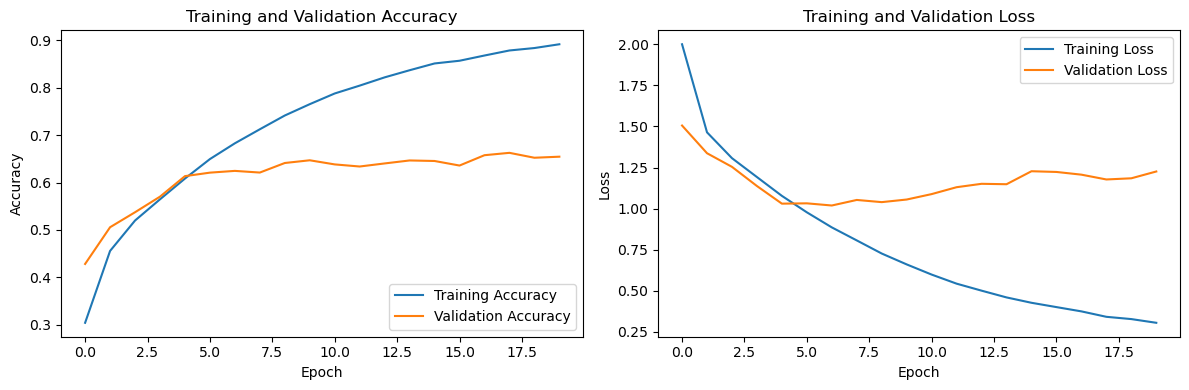

In [31]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
#plt.savefig('training_history.png')
print("Training history plot saved as training_history.png")
plt.show()

1/1 [==============================] - 0s 259ms/step
Test predictions plot saved as test_predictions.png


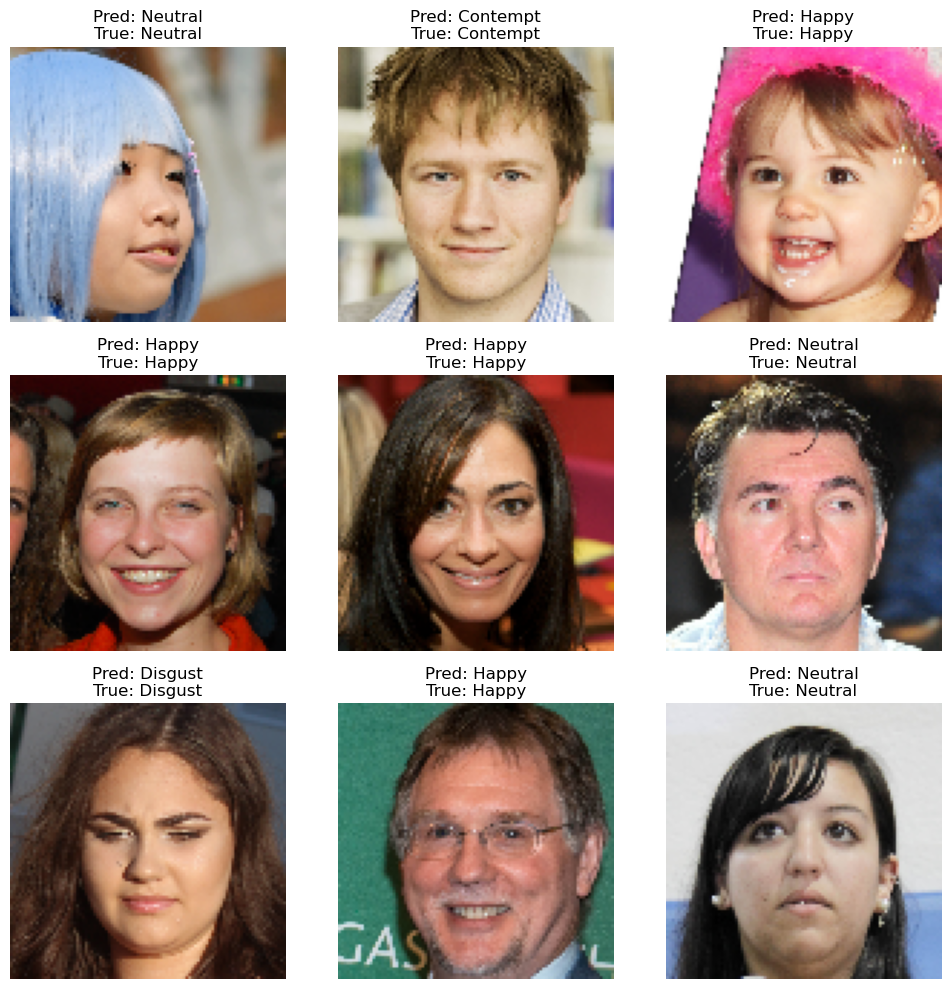

In [32]:
plt.figure(figsize=(10, 10))
# Take one batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    for i in range(9): # Display first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()) # No need for .astype("uint8") due to [0,1] scaling
        predicted_class = np.argmax(predictions[i])
        true_class = labels[i].numpy()
        plt.title(f"Pred: {CLASS_NAMES[predicted_class]}\nTrue: {CLASS_NAMES[true_class]}")
        plt.axis("off")
plt.tight_layout()
#plt.savefig('test_predictions.png')
print("Test predictions plot saved as test_predictions.png")
plt.show()

In [33]:
print("Calculating and plotting confusion matrix...")

# Get predictions and true labels for the entire test set
y_pred_list = []
y_true_list = []

# Iterate over the test dataset batches
for images, labels in test_dataset:
    preds = model.predict(images)
    y_pred = np.argmax(preds, axis=1)
    y_true = labels.numpy() # Get true labels for the batch

    y_pred_list.extend(y_pred)
    y_true_list.extend(y_true)

# Convert lists to numpy arrays
y_pred_np = np.array(y_pred_list)
y_true_np = np.array(y_true_list)

Calculating and plotting confusion matrix...
1/1 [==============================] - 0s 17ms/step


Confusion matrix plot saved as confusion_matrix.png


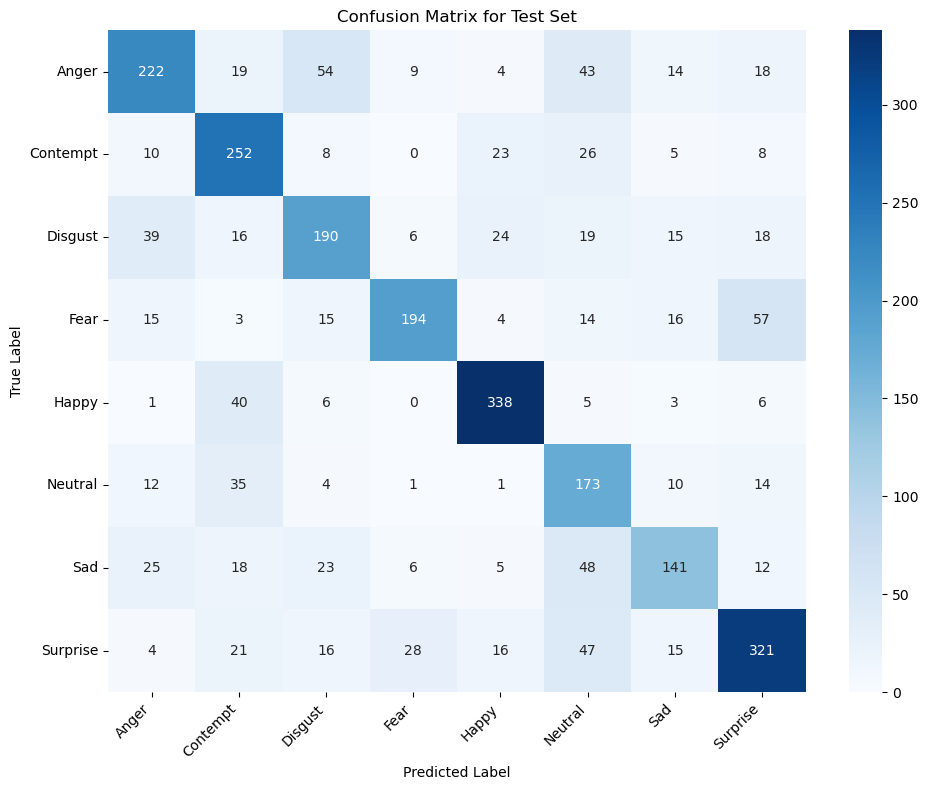

In [34]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true_np, y_pred_np)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('confusion_matrix.png')
print("Confusion matrix plot saved as confusion_matrix.png")
plt.show()

In [36]:
 # CLASS_NAMES = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
print("\nClassification Report:")
report = classification_report(y_true_np, y_pred_np, target_names=CLASS_NAMES)
print(report)


Classification Report:
              precision    recall  f1-score   support

       Anger       0.68      0.58      0.62       383
    Contempt       0.62      0.76      0.68       332
     Disgust       0.60      0.58      0.59       327
        Fear       0.80      0.61      0.69       318
       Happy       0.81      0.85      0.83       399
     Neutral       0.46      0.69      0.55       250
         Sad       0.64      0.51      0.57       278
    Surprise       0.71      0.69      0.70       468

    accuracy                           0.66      2755
   macro avg       0.67      0.66      0.65      2755
weighted avg       0.68      0.66      0.67      2755



cv prediction

In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

In [51]:
emotion_model2 = load_model('epoch20/dcnn_model1.h5.keras')
emotion_labels = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [52]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract face ROI and preprocess
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, (96, 96))              # Resize to model's input size
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)    # Convert BGR to RGB
        face = face.astype('float32') / 255.0           # Normalize
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0)             # Add batch dimension

        # Predict emotion
        prediction = emotion_model.predict(face)[0]
        emotion_probability = np.max(prediction)
        emotion_label = emotion_labels[prediction.argmax()]

        # Draw rectangle and label
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, f'{emotion_label}: {emotion_probability:.2f}', 
                    (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Emotion Detection', frame)

    # Break on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 12ms/step


NewTestImages

In [21]:
from PIL import Image
import glob
import os

In [58]:
TEST_IMAGES_FOLDER = r"c:\Users\Pojesh\Documents\OfficialWorks\MV_Project\Working\NewTestImages"
CLASS_NAMES = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [45]:
model = tf.keras.models.load_model('epoch20/dcnn_model1.h5.keras')

In [59]:
IMG_SIZE = (96,96)
def preprocess_image(image_path):
    # Load and resize image
    img = Image.open(image_path)
    img = img.convert('RGB')  # Ensure RGB format
    img = img.resize(IMG_SIZE)
    
    # Convert to numpy array and normalize
    img_array = np.array(img) / 255.0
    
    return img_array

In [63]:
image_files = []
for ext in ['*.jpg', '*.jpeg', '*.png']:
    image_files.extend(glob.glob(os.path.join(TEST_IMAGES_FOLDER, ext)))

# Sort the files to ensure consistent order
image_files = sorted(image_files)

Image: test01.jpg
Predicted emotion: Neutral
Confidence: 65.83%
------------------------------
Image: test02.jpg
Predicted emotion: Sad
Confidence: 52.21%
------------------------------
Image: test03.jpg
Predicted emotion: Contempt
Confidence: 62.17%
------------------------------
Image: test04.jpg
Predicted emotion: Fear
Confidence: 66.85%
------------------------------
Image: test05.jpg
Predicted emotion: Neutral
Confidence: 35.80%
------------------------------
Image: test06.jpg
Predicted emotion: Neutral
Confidence: 63.68%
------------------------------


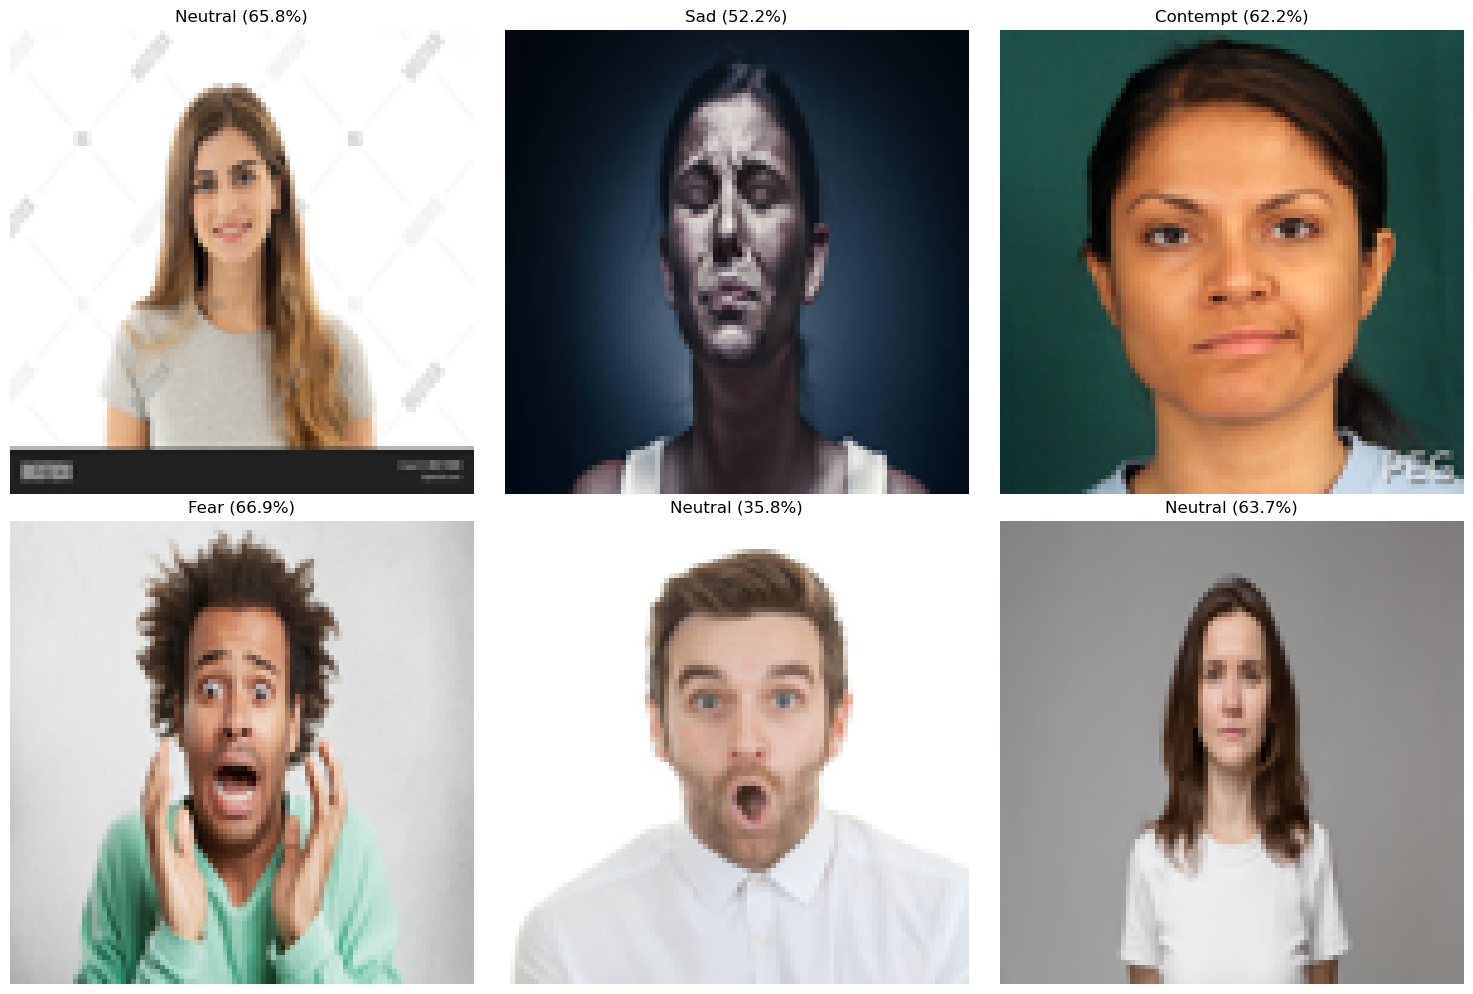

In [65]:
if not image_files:
    print(f"No image files found in {TEST_IMAGES_FOLDER}")
else:
    # Calculate grid dimensions
    num_images = len(image_files)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division
    
    # Create figure with appropriate size
    plt.figure(figsize=(15, 5 * num_rows))
    
    # Process each image and display results
    for i, image_path in enumerate(image_files):
        # Preprocess image
        img_array = preprocess_image(image_path)
        
        # Make prediction
        prediction = model.predict(np.expand_dims(img_array, axis=0), verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class] * 100
        
        # Get the emotion label
        emotion = CLASS_NAMES[predicted_class]
        
        # Display image with prediction
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img_array)
        plt.title(f"{emotion} ({confidence:.1f}%)")
        plt.axis('off')
        
        # Print prediction details
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Predicted emotion: {emotion}")
        print(f"Confidence: {confidence:.2f}%")
        print("-" * 30)
    
    plt.tight_layout()
    plt.show()

Image: test01.jpg
Predicted emotion: Neutral
Confidence: 65.83%
Second prediction: Contempt
Second confidence: 13.22%
------------------------------
Image: test02.jpg
Predicted emotion: Sad
Confidence: 52.21%
Second prediction: Fear
Second confidence: 33.57%
------------------------------
Image: test03.jpg
Predicted emotion: Contempt
Confidence: 62.17%
Second prediction: Neutral
Second confidence: 31.16%
------------------------------
Image: test04.jpg
Predicted emotion: Fear
Confidence: 66.85%
Second prediction: Sad
Second confidence: 22.35%
------------------------------
Image: test05.jpg
Predicted emotion: Neutral
Confidence: 35.80%
Second prediction: Surprise
Second confidence: 32.19%
------------------------------
Image: test06.jpg
Predicted emotion: Neutral
Confidence: 63.68%
Second prediction: Happy
Second confidence: 22.09%
------------------------------


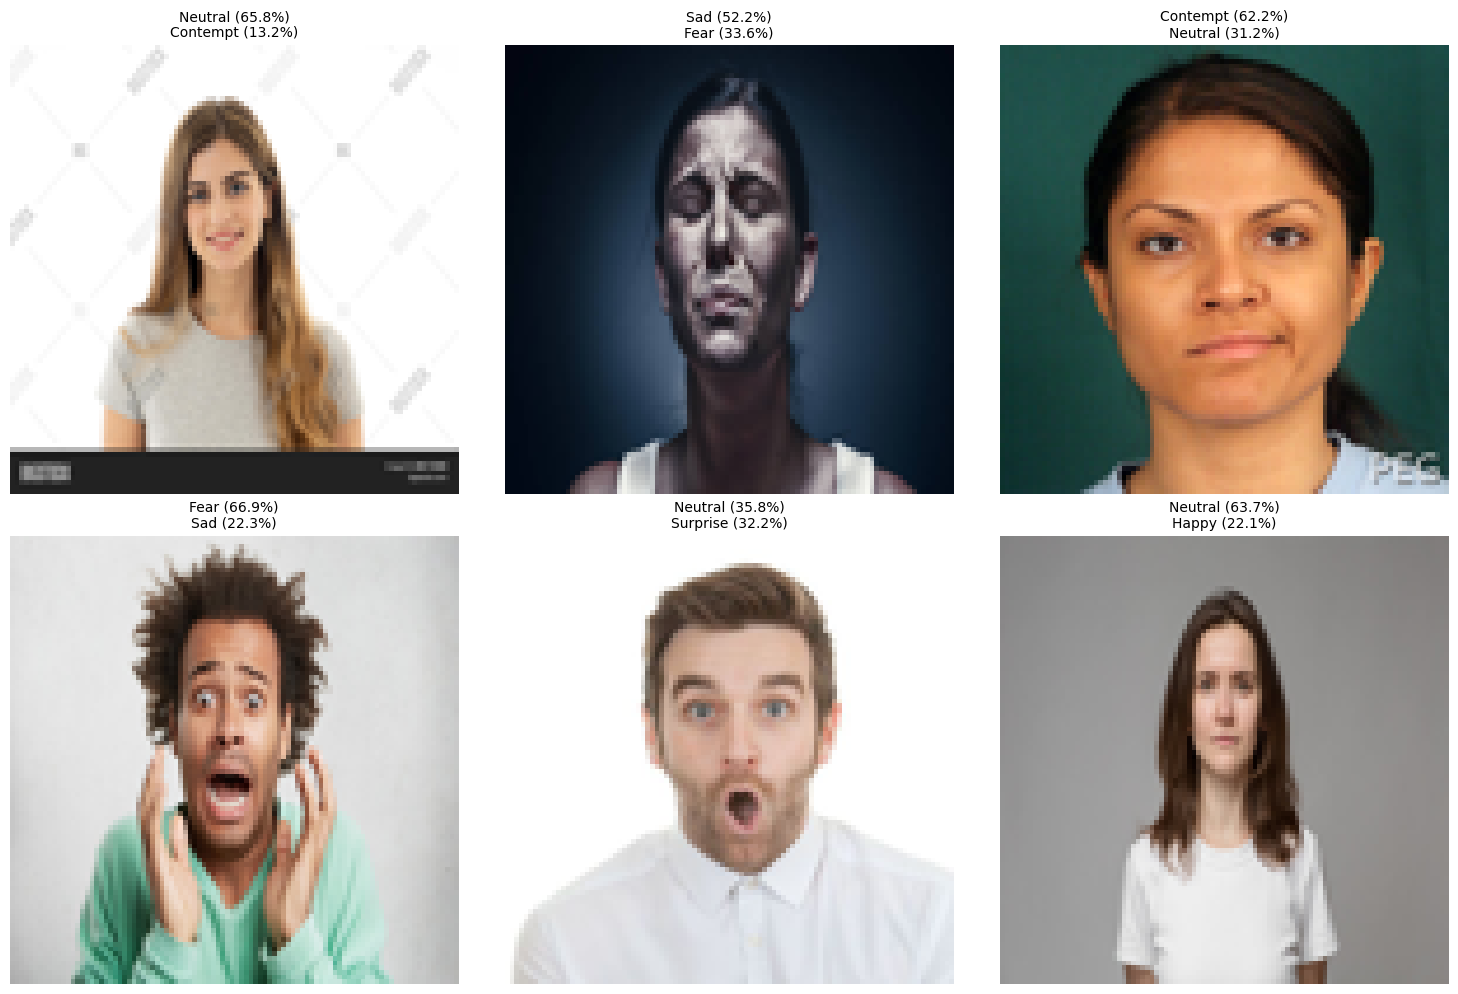

In [66]:
if not image_files:
    print(f"No image files found in {TEST_IMAGES_FOLDER}")
else:
    # Calculate grid dimensions
    num_images = len(image_files)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division
    
    # Create figure with appropriate size
    plt.figure(figsize=(15, 5 * num_rows))
    
    # Process each image and display results
    for i, image_path in enumerate(image_files):
        # Preprocess image
        img_array = preprocess_image(image_path)
        
        # Make prediction
        prediction = model.predict(np.expand_dims(img_array, axis=0), verbose=0)
        
        # Get top 2 predictions
        top_indices = np.argsort(prediction[0])[-2:][::-1]  # Get indices of top 2 predictions
        
        # First (highest) prediction
        predicted_class = top_indices[0]
        confidence = prediction[0][predicted_class] * 100
        emotion = CLASS_NAMES[predicted_class]
        
        # Second highest prediction
        second_class = top_indices[1]
        second_confidence = prediction[0][second_class] * 100
        second_emotion = CLASS_NAMES[second_class]
        
        # Display image with prediction
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img_array)
        plt.title(f"{emotion} ({confidence:.1f}%)\n{second_emotion} ({second_confidence:.1f}%)", fontsize=10)
        plt.axis('off')
        
        # Print prediction details
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Predicted emotion: {emotion}")
        print(f"Confidence: {confidence:.2f}%")
        print(f"Second prediction: {second_emotion}")
        print(f"Second confidence: {second_confidence:.2f}%")
        print("-" * 30)
    
    plt.tight_layout()
    plt.show()